# Install libraries 


In [126]:
import sys, os, json
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation


## torch libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_new_Artur

import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CWL DATASET Set all hyperparameters
- Cuda and GPU.
- Parameters of dataset. 
- random seed( if necessary). 


In [127]:
print(torch.cuda.is_available(), torch.cuda.device_count())
torch.cuda.set_device(0)

config = dict(  
                dataset_name = 'CWL_raw', # CWL
                fps = 1000,
                patients = 'trio1',
                new_fps=100, 
                crop_start = 5,
                freqs = [-1], 
    
                n_channels = 30, # 63 
                n_roi = 8,
                
                bold_delay = 6,
                to_many = True,
                random_subsample = True,
                sample_per_epoch = 512, 
                WINDOW_SIZE = 2048,
                    
                optimizer='adamW',
                lr=3e-4,
                weight_decay=3e-4, 
                batch_size=16, 
                
                preproc_type = 'dB_log',
                loss_function = 'mse_corr', 
                model_type = 'Best_AE_Artur_Multi_Head'
                )


hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],

                     channels = [128, 128, 128, 128], 
                     kernel_sizes=[5, 5, 3],
                     strides=[8, 8, 4,], 
                     dilation=[1, 1, 1], 
                     decoder_reduce=4, 
                      hidden_channels=16
                     )


config = {**hp_autoencoder, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

True 4


# Upload RAW CWL data for Artur Model 
It should accelerate speed of experiments.

Size of train dataset: (30, 20590) (8, 20590)
Size of test dataset: (30, 5400) (8, 5400)
3351
ALL path:  ../data/eyes_open_closed_dataset/trio1/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_normalized/rwatrio1_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_motionparams/rp_atrio1_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (303601, 31)
Dimension of our fMRi data:  (61, 72, 61, 146)
Dimension of our fMRi Roi data:  (143, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


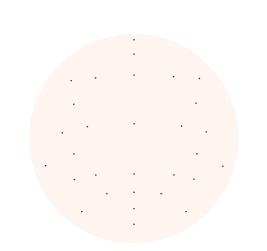

(<matplotlib.image.AxesImage at 0x7f6687cd1a60>,
 <matplotlib.contour.QuadContourSet at 0x7f6687cd1d60>)

In [128]:
with open("../data/interim/labels_roi_17.json", 'r') as f:
    labels_roi_17 = json.load(f)
    
labels_roi = ['Left Pallidum',
                     'Left Caudate',
                     'Left Putamen',
                     'Left Accumbens',
                      
                     'Right Pallidum',
                     'Right Caudate',
                     'Right Putamen',
                     'Right Accumbens']


if config['dataset_name']=='CWL_raw':
    
    dataset_path = f"../data/interim/CWL/{config['patients']}_1000_filtered_data.npz"

elif config['dataset_name']=='NODDI_raw':
    dataset_path = '../data/interim/NODDI/32_250_filtered_data.npz'
else:
    print('no such dataset')



data = np.load(dataset_path)

eeg, fmri = data['eeg'], data['fmri']
df = pd.DataFrame(data = fmri.T, columns=labels_roi_17)
df_filter = df[labels_roi]
fmri = df_filter.to_numpy().T

# crop start
train_crop = config['crop_start']*config['fps']
eeg, fmri = eeg[..., train_crop:], fmri[..., train_crop:]

# normalize 
eeg = eeg / np.std(eeg)
fmri, fmri_means_stds = preproc.normalize_data(fmri)

# train/test split
test_time = int(60*config['fps'])
train_dataset_prep = (eeg[..., :-test_time], fmri[..., :-test_time])
test_dataset_prep = (eeg[..., -test_time:], fmri[..., -test_time:])


ds_factor = config['fps']/config['new_fps']
train_dataset_prep = preproc.downsample_dataset(train_dataset_prep, factor = ds_factor)
test_dataset_prep = preproc.downsample_dataset(test_dataset_prep, factor = ds_factor)





# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                   config['new_fps'],
                                                   config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                  config['new_fps'],
                                                  config['bold_delay'])


print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

# torch dataset creation 
torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            random_sample=config['random_subsample'], 
                                                            sample_per_epoch=config['sample_per_epoch'], 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                            random_sample=False, 
                                                            sample_per_epoch=None, 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])
print(len(torch_dataset_test))
# because you do not have strid for val data. 
torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

# init dataloaders for training
train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
val_loader = torch.utils.data.DataLoader(torch_dataset_test, **params_val)



#----------------------------------------------------#
### INFO FOR TOPOMAPS CWL 
patient = 'trio1'
path_to_dataset = '../data/eyes_open_closed_dataset/'
dataset_name = 'CWL'
remove_confounds = True

df_eeg, df_fmri, _ = get_datasets.download_cwl_dataset(patient, path_to_dataset, 
                                                                    remove_confounds=remove_confounds,
                                                                    verbose=True)

standart_montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=standart_montage.ch_names, sfreq=100, ch_types='eeg')
info = info.pick_channels(ch_names = list(df_eeg.columns)[1:])

epochs = mne.EpochsArray(np.zeros([1, len(info.ch_names), 1]),  info=info)
epochs.set_montage(standart_montage)
info = epochs.info
x = np.zeros(30)
mne.viz.plot_topomap(x, pos = info)

# Model Inference

## Init Model

In [129]:
hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],

                     channels = [128, 128, 128, 128], 
                     kernel_sizes=[5, 5, 3],
                     strides=[8, 8, 4,], 
                     dilation=[1, 1, 1], 
                     decoder_reduce=4, 
                      hidden_channels=16
                     )
weight_path = 'wandb/run-20220517_155127-1myycb0h/files/epoch_1564_val_corr0.48.pt'

model = autoencoder_new_Artur.AutoEncoder1D_Artur_MultiHead(hp_autoencoder)

print(summary(model, torch.zeros(4, config['n_channels'],
                                 config['WINDOW_SIZE']), show_input=False))


model.load_state_dict(torch.load(weight_path))
model.eval()

print('s')

HOW:  {'n_electrodes': 30, 'n_freqs': 1, 'n_channels_out': 8, 'channels': [128, 128, 128, 128], 'kernel_sizes': [5, 5, 3], 'strides': [8, 8, 4], 'dilation': [1, 1, 1], 'decoder_reduce': 4, 'hidden_channels': 16}
HUI 8
-----------------------------------------------------------------------------
            Layer (type)        Output Shape         Param #     Tr. Param #
   AutoEncoder1D_Artur-1        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-2        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-3        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-4        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-5        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-6        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-7        [4, 1, 2048]         245,057         245,057
   AutoEncoder1D_Artur-8        [4, 1, 2048]         245,057         245,057
Total param

(8, 5120)
(8, 5120)


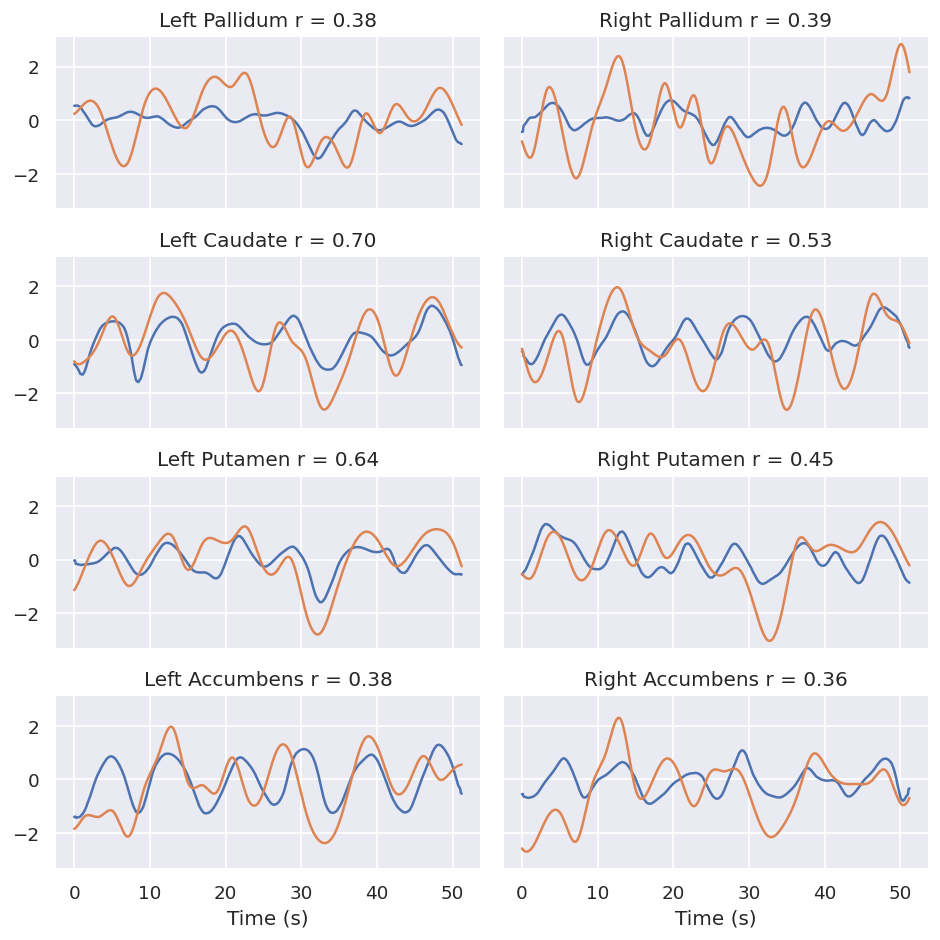

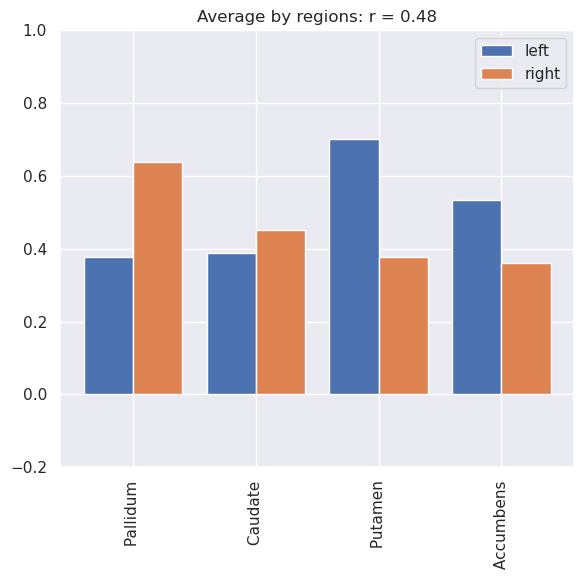

In [134]:
raw_test_data = test_dataset_prep
# labels = labels_roi_6
labels = labels_roi

inference_function = inference.model_inference_function
device = 'cuda'
to_many = True

fig, fig_bars, corrs = inference_function(model, raw_test_data, 
                                          labels=labels, 
                                          device=device, 
                                          to_many=to_many)



In [135]:
fig.savefig('../figures/ts_best_MH_Artur_AE_8_ROI_0_48_final.pdf')
# fig_bars.savefig('../figures/bars_best_MH_Artur_AE_0_47.pdf') 

# Model Interpretation 


## Apply patterns interpretation

In [136]:
from sklearn.preprocessing import minmax_scale

def extract_spatial_patterns(eeg, weights, freq_filters):
    """
    eeg - (30,
    weights shape (n_branch, n_elcctrodes ) 
    
    
    freq_filters - [5, 1, 51]
    
    1. Apply band pass filter for all weight 
    2. Get covariance of the filtered data 
    3. Multiply covariance on the weights
    """
    n_heads, n_electrodes = weights.shape
    
    patterns_list = []
    
    for head_idx in range(n_heads):
        
        weight = weights[head_idx]
        freq_weight = freq_filters[head_idx] # [1, 51]

        # 1  apply band filter 
        X = eeg.unsqueeze(0).float()    
        freq_weight = freq_weight.repeat(n_electrodes, 1, 1)
        X_filter = F.conv1d(X, freq_weight, padding ='same', groups=n_electrodes)[0]

        # 2 Take covariance
        X_filter_cov = torch.cov(X_filter)

        # 3. Get patterns  
        pattern = torch.matmul(X_filter_cov, weight)
        patterns_list.append(pattern)
    return torch.stack(patterns_list)
    
def compute_fft(data, fps):
    """
    Return (freqs, amplitudes)
    """
    n = data.shape[0]
    values = torch.fft.rfft(data, n=n, norm ='forward' )[:n//2] # forward means 1/n
    freqs = torch.fft.fftfreq(n=n, d=1/fps)[:values.shape[0]]
    return freqs, values

def extract_freq_patterns(eeg, weights, freq_filters, fps = 100):
    """
    eeg - (30,
    weights shape (n_branch, n_elcctrodes ) 
    
    
    freq_filters - [5, 1, 51]
    
    
    Return 
        freqs_list_kernel, torch.stack(patterns_list), torch.stack(patterns_list)
    list of freqs, patterns for all roi, weights for all roi
    """
    n_heads, n_electrodes = weights.shape
    
    patterns_list = []
    fft_kernels_list= []
    fft_signal_list = []
    
    for head_idx in range(n_heads):
        
        weight = weights[head_idx]
        freq_weight = freq_filters[head_idx][0] # [51]
        X = eeg.unsqueeze(0).float()
        
        # 1  apply spatial filter        
        X_one_head = torch.matmul(weight, X)[0]
        
        
        # 1. approach.
#         freq_weight = freq_weight.reshape((1, 1, -1))
#         X_one_head = X_one_head.reshape((1, 1,-1)) 
#         X_head_filter = F.conv1d(X_one_head, freq_weight, padding ='same', groups=1)[0][0]
#         freqs_list, values = compute_fft(X_head_filter, 100)
#         values = torch.abs(values)
        
#         values = F.interpolate(values.reshape(1, 1, -1), size=freq_weight.shape[-1]//2, mode='nearest').squeeze()
#         patterns_list.append(values)
        
        # 2. 
        
        freqs_list_kernel, fft_kernel = compute_fft(freq_weight, fps)
        freqs_list_signal, fft_signal = compute_fft(X_one_head, fps)
        fft_kernel =  torch.abs(fft_kernel)
        fft_signal = torch.abs(fft_signal)
        
        # take the same as kernel
        fft_signal_interp = F.interpolate(fft_signal.reshape(1, 1, -1), 
                                          size=fft_kernel.shape[0], mode='nearest').squeeze()
        
        
        # fft_kernel = minmax_scale(fft_kernel.reshape(1, -1), axis =-1)[0]
        pattern = fft_signal_interp * fft_kernel
        
        
        fft_kernels_list.append(fft_kernel)
        patterns_list.append(pattern)
        
    freqs_list_kernel, fft_kernel = compute_fft(freq_weight.squeeze(), fps)
    return freqs_list_kernel, torch.stack(patterns_list), torch.stack(fft_kernels_list) 
    


## Calculate all patterns

In [137]:
all_spatial_patterns = []
all_freq_patterns = []
all_freq_weights = []


n_roi = len(labels)
for roi_idx in range(n_roi):
    model_roi = model.models[roi_idx]

    weights = torch.squeeze(model_roi.artur_block.unmixing_layer.weight).detach().cpu()
    freq_filters = model_roi.artur_block.band_pass.weight.cpu().detach()
    eeg = torch.from_numpy(raw_test_data[0]).float()
    
    print('ALL sizes:', weights.shape, freq_filters.shape, eeg.shape)

    spatial_patterns = extract_spatial_patterns(eeg, weights, freq_filters)
    freqs_list, fft_patterns, fft_weights = extract_freq_patterns(eeg, weights, freq_filters)
    
    
    all_spatial_patterns.append(spatial_patterns)
    all_freq_patterns.append(fft_patterns)
    all_freq_weights.append(fft_weights)
    
    

ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])
ALL sizes: torch.Size([16, 30]) torch.Size([16, 1, 51]) torch.Size([30, 5400])


## Get the most influential braches based on gradients 

In [138]:
from captum.attr import Saliency, LayerFeatureAblation, LayerGradientXActivation
x_batch = np.expand_dims(raw_test_data[0], 0).astype('float32')
x_batch = torch.tensor(x_batch, requires_grad=True).cpu()
# x_batch.grad.zero_()
# Gradient by some layers. 

top_branches = 3

all_top_idxs = []
for roi_idx in range(n_roi):
    one_model = model.models[roi_idx].cpu()
    layer = LayerGradientXActivation(one_model, one_model.artur_block)
    # for all prediction.
    layer_attr = []
    for t in range(0, x_batch.shape[-1], 100):
        attr = layer.attribute(x_batch, target=(0, t))
        attr = np.abs(attr.detach().numpy()[0])
        attr = np.mean(attr, -1)
        layer_attr.append(attr)

    # average across time 
    layer_attr = np.stack(layer_attr, 0)
    branch_influence = np.mean(layer_attr, 0)
    # take top the most influential
    sorted_idxs = np.argsort(branch_influence)
    top_idxs = sorted_idxs[-top_branches:]
    all_top_idxs.append(top_idxs)
all_top_idxs = np.stack(all_top_idxs, 0).astype('int')

In [139]:

# get best branches
all_spatial_patterns = [pat[idxs] for pat, idxs in zip(all_spatial_patterns, all_top_idxs)]
all_freq_weights = [pat[idxs] for pat, idxs in zip(all_freq_weights, all_top_idxs)]

## Plot topomaps 

### Topomaps

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

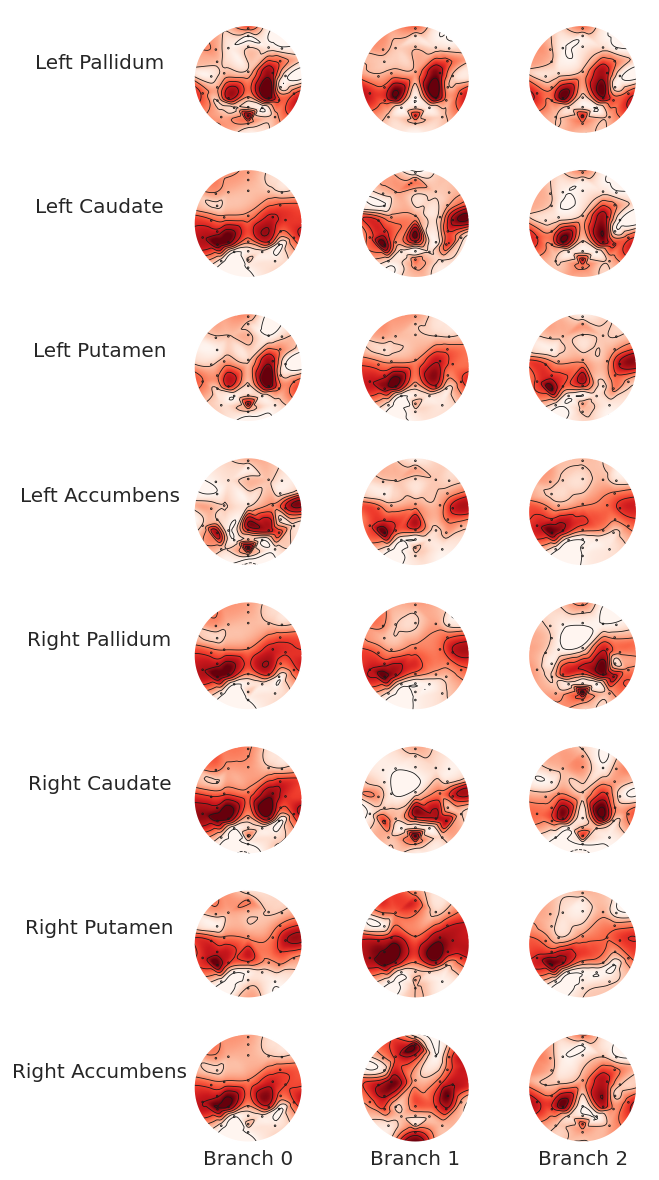

In [140]:
n_branch = top_branches
fig, ax = plt.subplots(n_roi, n_branch, figsize = (6, 10), sharex=True, dpi = 120,squeeze=False)
for roi in range(n_roi):
    # get v_min and v_max for each RoI
    # vmax = np.max([torch.max(pat) for pat in all_spatial_patterns[roi]])
    # vmin = np.min([torch.min(pat) for pat in all_spatial_patterns[roi]])
        # get v_min and v_max for each RoI
    # vmax = np.max([torch.max(torch.abs(pat)) for pat in all_spatial_patterns[roi]])
    # vmin = np.min([torch.min(torch.abs(pat)) for pat in all_spatial_patterns[roi]])
    # print(vmin, vmax)
    
    for i in range(n_branch):
        # mne.viz.plot_topomap(all_spatial_patterns[roi][i], pos = info,
        #                      vmin = vmin, vmax =vmax, show=False, axes = ax[roi, i])
        mne.viz.plot_topomap(torch.abs(all_spatial_patterns[roi][i]), pos = info, show=False, axes = ax[roi, i], 
                            extrapolate='head')
        ax[roi, i].set(xlabel=f"Branch {i}")
        ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=50)
        


    
for ax in ax.flat:
    ax.label_outer()
# plt.colorbar()
plt.tight_layout()


In [141]:
# fig.savefig('../figures/all_topomaps_CWL_fixed_8_ROI_top_1.pdf')


## Plot time freq maps

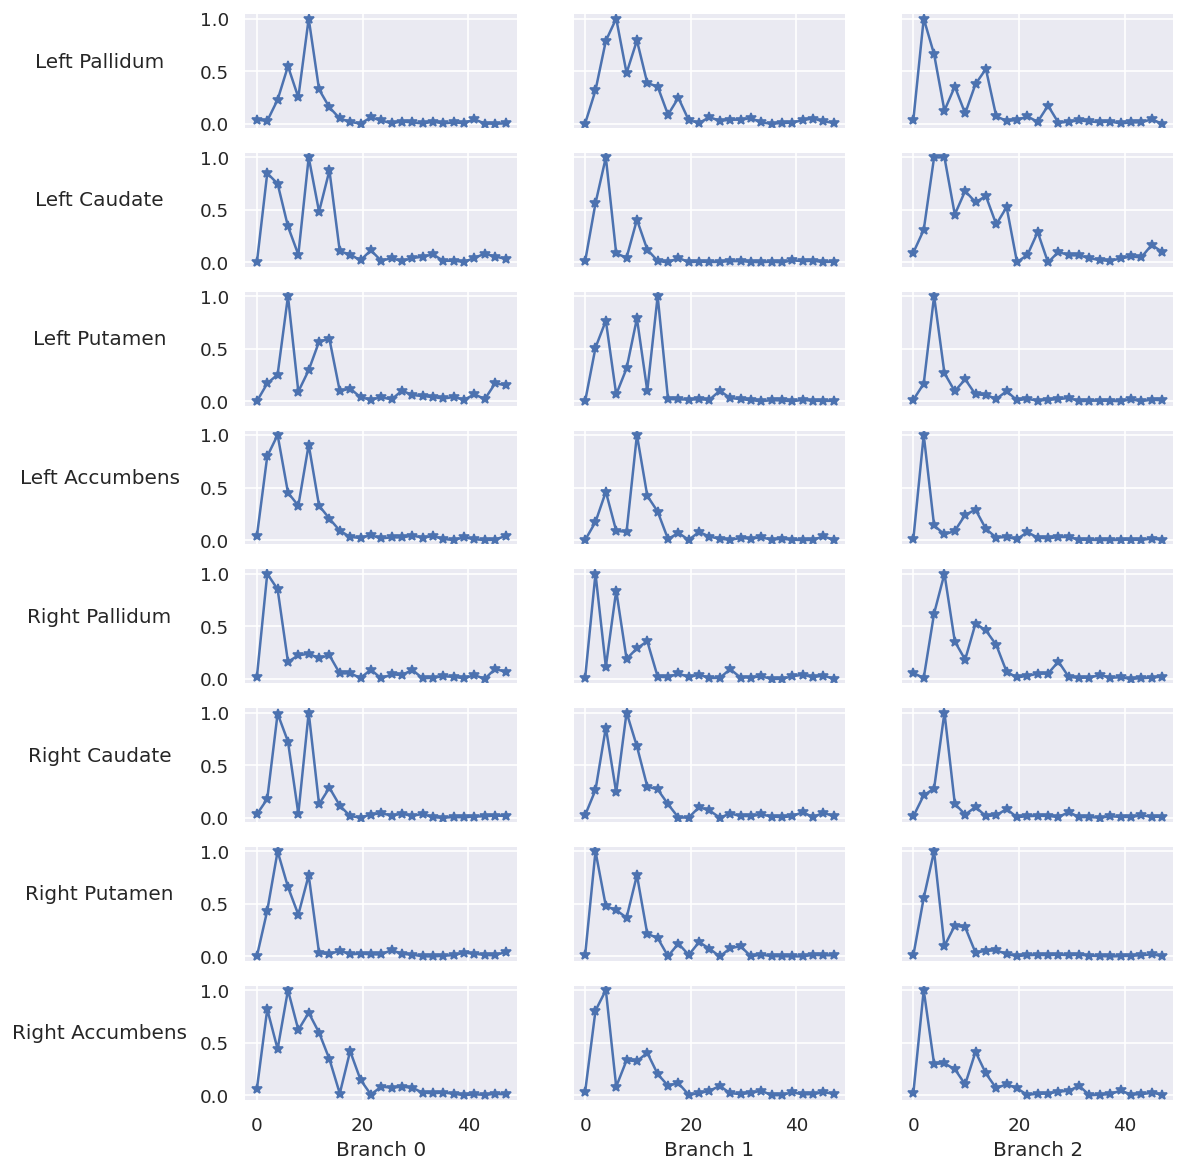

In [154]:
from sklearn.preprocessing import MinMaxScaler

n_roi = len(labels)
n_branch = top_branches
fig, ax = plt.subplots(n_roi, n_branch, figsize = (10, 12), sharex=True, sharey=True,squeeze=False, dpi=120)
for roi in range(n_roi):
    # vmax = np.max([torch.max(pat) for pat in all_freq_patterns[roi]])
    # vmax_weight = np.max([torch.max(pat) for pat in all_freq_weights[roi]])
    scaler = MinMaxScaler()
    # scaler.fit(all_freq_patterns[roi].reshape(-1, 1))
    
    # scaler_weight = MinMaxScaler()
    # scaler_weight.fit(all_freq_weights[roi].reshape(-1, 1))
    # scaler.fit(all_freq_patterns[roi].T)
    
    
    for i in range(n_branch):
        # pattern = minmax_scale(all_freq_patterns[roi][i].reshape(1, -1),axis= -1)[0]
        # weight = minmax_scale(all_freq_weights[roi][i].reshape(1, -1),axis= -1)[0]
#         pattern = all_freq_patterns[roi][i] / vmax
#         weight = all_freq_weights[roi][i] / vmax_weight
        
        # pattern = np.convolve(pattern, np.ones(5)/5, 'SAME')
#         weight = np.convolve(weight, np.ones(5)/5, 'SAME')
        
        pattern = all_freq_patterns[roi][i]
        weight = all_freq_weights[roi][i]

        
        # scale to minmax for all RoI
        
        pattern = scaler.fit_transform(pattern.reshape(-1, 1))[:, 0]
        weight = scaler.transform(weight.reshape(-1, 1))[:, 0]


        
        # pattern = np.convolve(pattern, np.ones(3)/3, 'SAME')
        # weight = np.convolve(weight, np.ones(3)/3, 'SAME')


        ax[roi, i].plot(freqs_list, pattern , '*-', label='patterns(smooth)')
        # ax[roi, i].plot(freqs_list, weight  , '*-', label='weights')
        

        # mne.viz.plot_topomap(all_freq_patterns[roi][i], pos = info, show=False, axes = ax[roi, i])
        ax[roi, i].set(xlabel=f"Branch {i}")
        ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=60)
    

    
#     
    

for ax in ax.flat:
    # ax.set(xlabel='x-label', ylabel='y-label')
    ax.label_outer()
    # ax.set_xticklabels(labels, rotation=45, ha='right')



# for ax in fig.axes:
axLine, axLabel = fig.axes[0].get_legend_handles_labels()


    
# fig.legend(axLine, axLabel,           
#            loc = 'right')
# for ax in axs.flat:
    

In [143]:
# fig.savefig('../figures/all_time_freq_maps_8_ROI_top_3_branch.pdf')

## Combine 

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

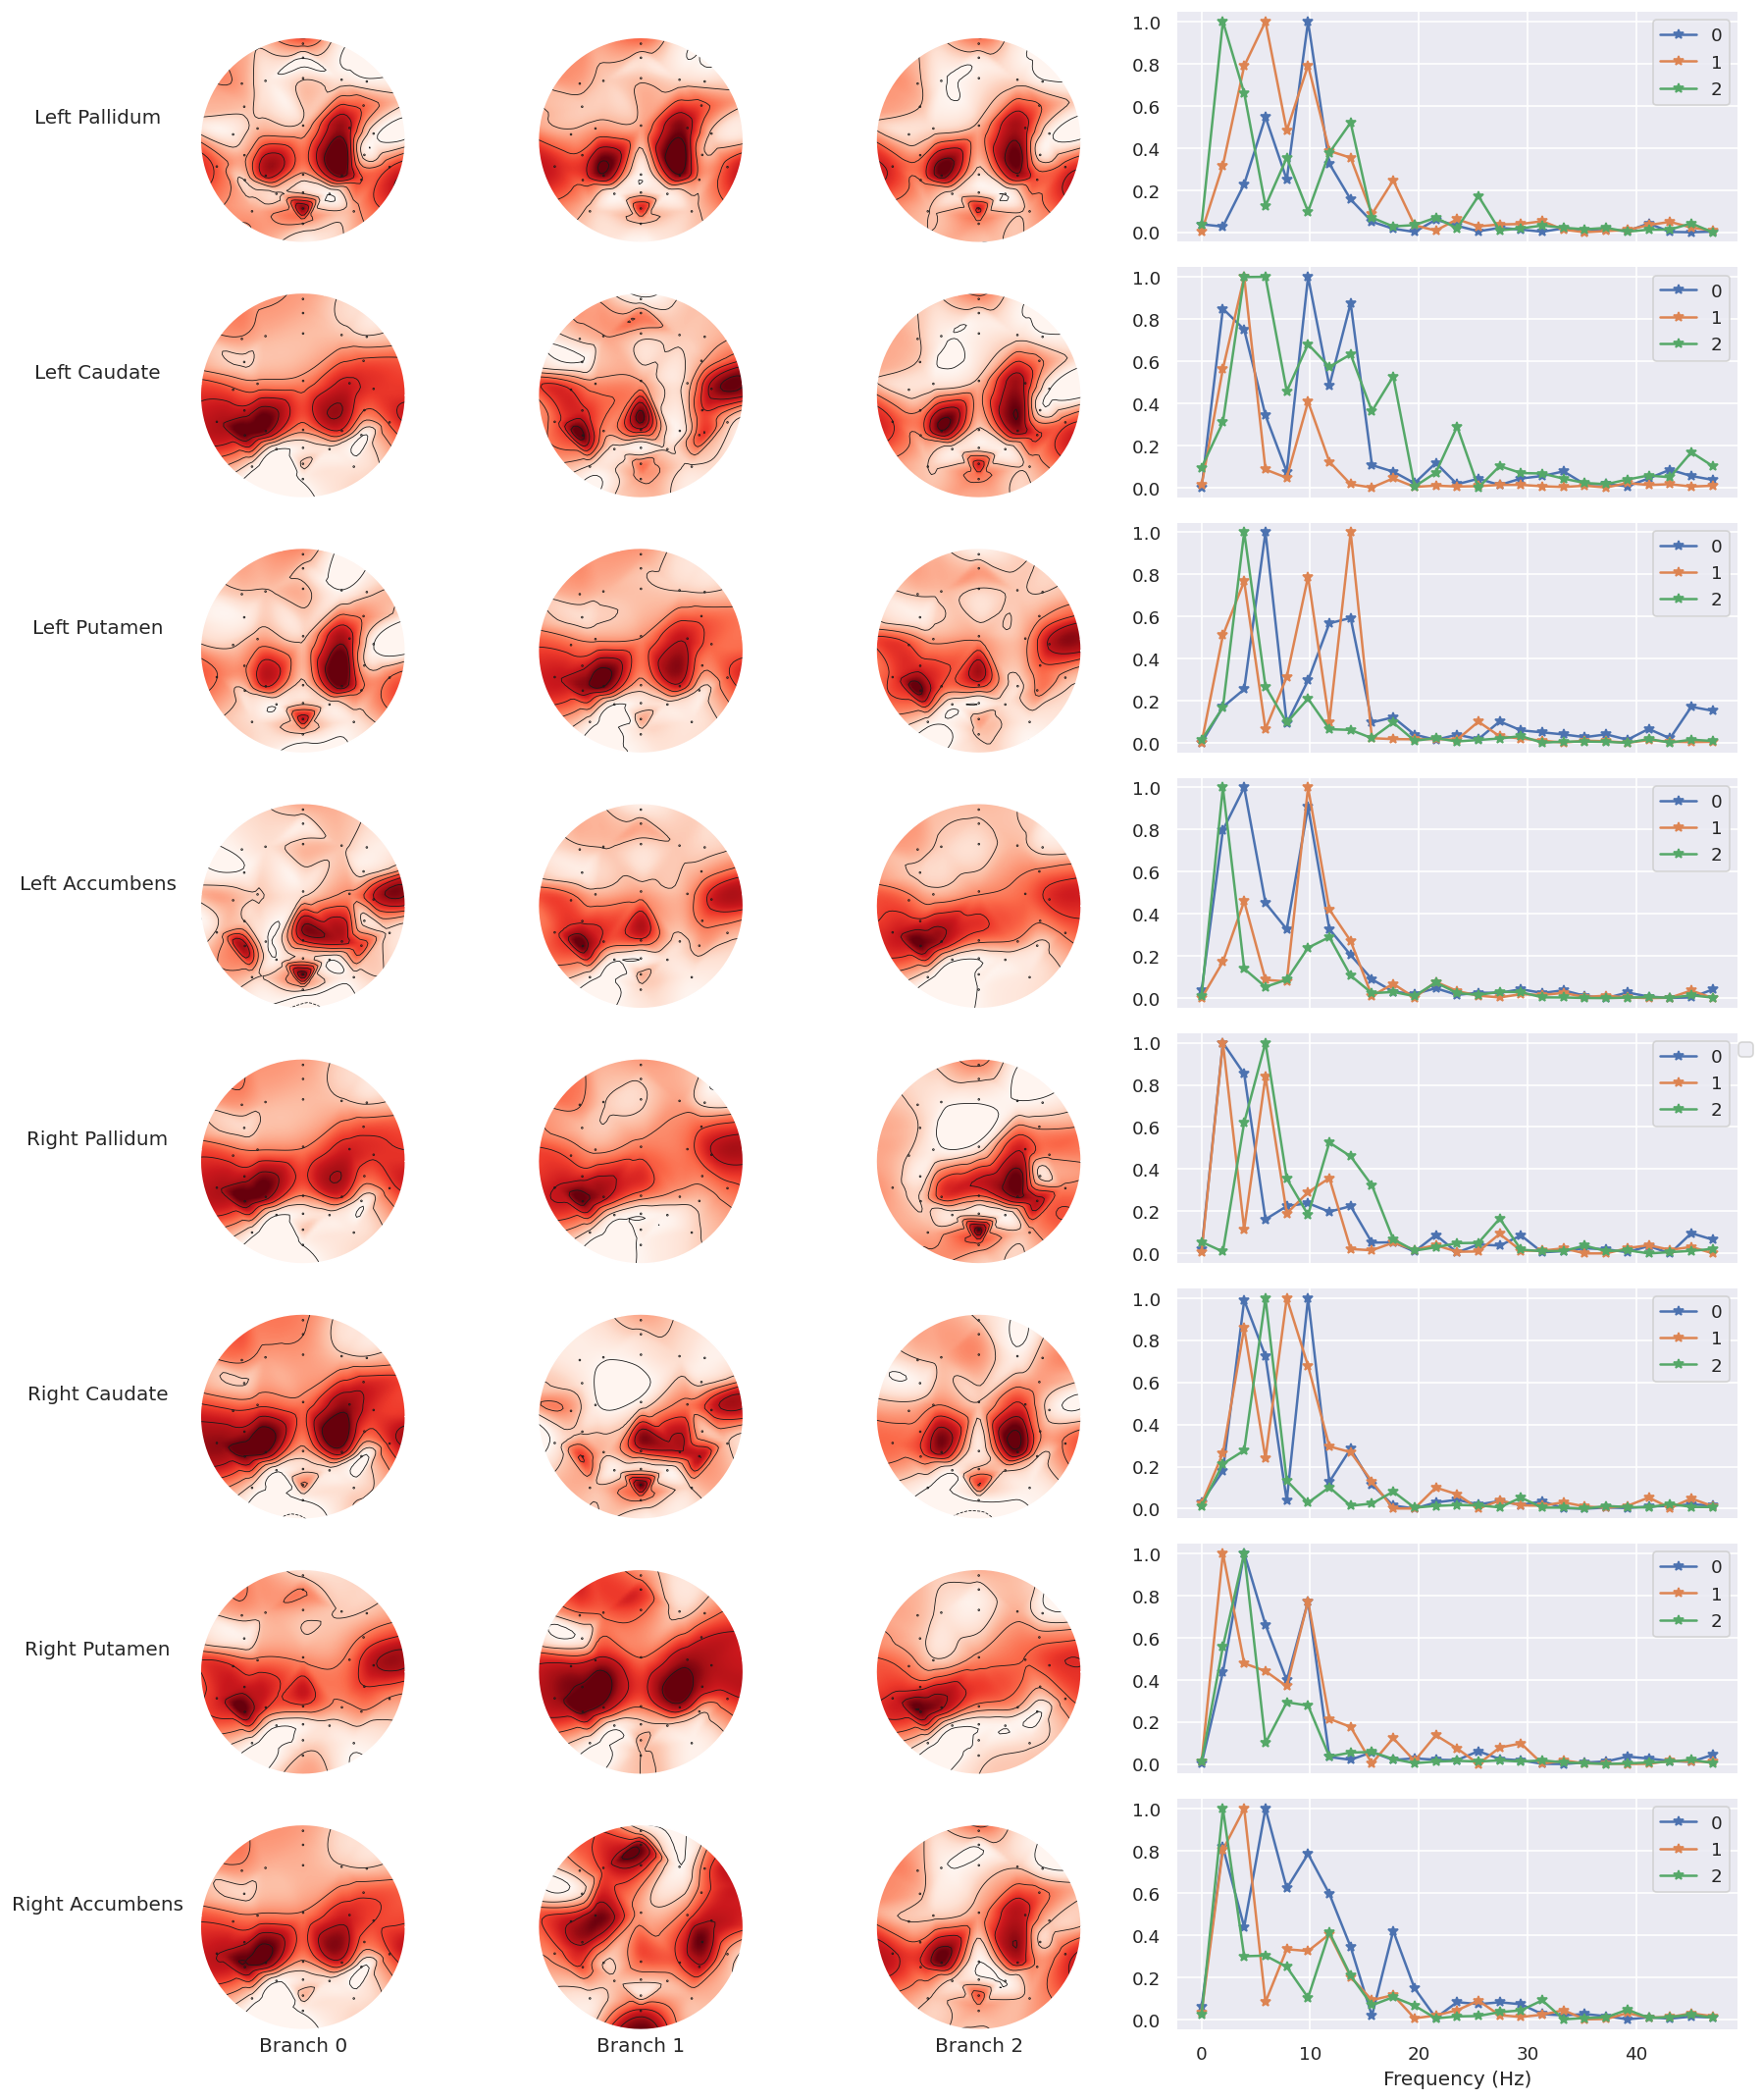

In [158]:
from sklearn.preprocessing import MinMaxScaler

n_roi = len(labels)
n_branch = top_branches
fig, ax = plt.subplots(n_roi, n_branch+1, figsize = (15, 18), sharex='col', sharey=False,squeeze=False, dpi=120, 
                      gridspec_kw={'width_ratios': [1, 1, 1, 2]})
for roi in range(n_roi):
    scaler = MinMaxScaler()    
    for i in range(n_branch):    
        pattern = all_freq_patterns[roi][i]
        pattern = scaler.fit_transform(pattern.reshape(-1, 1))[:, 0]
        # pattern = np.convolve(pattern, np.ones(3)/3, 'SAME')
        
        ax[roi, -1].plot(freqs_list, pattern , '*-', label='branch' + str(i))
        ax[roi, -1].legend("012 ",loc="upper right")
        # ax[roi, -1].set_xlabel('Frequency (Hz)')
        # ax[roi, -1].label_outer()
        # ax[roi, i].set(xlabel=f"Branch {i}")
        # ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=60)
    
ax[-1, -1].set_xlabel('Frequency (Hz)')


for roi in range(n_roi):
    for i in range(n_branch):
        mne.viz.plot_topomap(torch.abs(all_spatial_patterns[roi][i]), pos = info, show=False, axes = ax[roi, i], 
                            extrapolate='head')
        # mne.viz.plot_topomap(all_spatial_patterns[roi][i], pos = info, show=False, axes = ax[roi, i], 
                            # extrapolate='head')
        ax[roi, i].set(xlabel=f"Branch {i}")
        ax[roi, i].set_ylabel(f"{labels[roi]}", rotation=0, labelpad=50)
        ax[roi, i].label_outer()
        


plt.tight_layout()

# for ax in ax.flat:
#     ax.label_outer()



axLine, axLabel = fig.axes[0].get_legend_handles_labels()
fig.legend(axLine, axLabel,           
           loc = 'right')


# for ax in axs.flat:
    

In [159]:
fig.savefig('../figures/combine_all_ROI_8_3_branch_final_abs_v2.pdf')

# Upload RAW NODDI 

In [32]:
print(torch.cuda.is_available(), torch.cuda.device_count())
torch.cuda.set_device(0)

config = dict(  
                dataset_name = 'NODDI_raw', # CWL
                fps = 250,
                new_fps=100, 
                crop_start = 5,
                freqs = [-1], 
    
                n_channels = 63, # 30 
                n_roi = 6,
                
                bold_delay = 6,
                to_many = True,
                random_subsample = True,
                sample_per_epoch = 512, 
                WINDOW_SIZE = 2048,
                    
                optimizer='adamW',
                lr=3e-4,
                weight_decay=3e-4, 
                batch_size=16, 
                
                preproc_type = 'dB_log',
                loss_function = 'mse_corr', 
                model_type = 'Best_AE_Artur_Multi_Head'
                )


hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],

                     channels = [128, 128, 128, 128], 
                     kernel_sizes=[5, 5, 3],
                     strides=[8, 8, 4,], 
                     dilation=[1, 1, 1], 
                     decoder_reduce=4
                     )


config = {**hp_autoencoder, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

True 4


In [33]:
with open("../data/interim/labels_roi_17.json", 'r') as f:
    labels_roi_17 = json.load(f)

with open("../data/processed/labels_roi_6.json", 'r') as f:
    labels_roi_6 = json.load(f)

with open("../data/processed/labels_roi_6.json", 'r') as f:
    labels_roi = json.load(f)


if config['dataset_name']=='CWL_raw':
    dataset_path = '../data/interim/CWL/trio1_1000_filtered_data.npz'

elif config['dataset_name']=='NODDI_raw':
    dataset_path = '../data/interim/NODDI/32_250_filtered_data.npz'
else:
    print('no such dataset')



data = np.load(dataset_path)

eeg, fmri = data['eeg'], data['fmri']
df = pd.DataFrame(data = fmri.T, columns=labels_roi_17)
df_filter = df[labels_roi_6]
fmri = df_filter.to_numpy().T

# crop start
train_crop = config['crop_start']*config['fps']
eeg, fmri = eeg[..., train_crop:], fmri[..., train_crop:]

# normalize 
eeg = eeg / np.std(eeg)
fmri, fmri_means_stds = preproc.normalize_data(fmri)

# train/test split
test_time = int(60*config['fps'])
train_dataset_prep = (eeg[..., :-test_time], fmri[..., :-test_time])
test_dataset_prep = (eeg[..., -test_time:], fmri[..., -test_time:])


ds_factor = config['fps']/config['new_fps']
train_dataset_prep = preproc.downsample_dataset(train_dataset_prep, factor = ds_factor)
test_dataset_prep = preproc.downsample_dataset(test_dataset_prep, factor = ds_factor)





# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                   config['new_fps'],
                                                   config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                  config['new_fps'],
                                                  config['bold_delay'])


print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

# torch dataset creation 
torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            random_sample=config['random_subsample'], 
                                                            sample_per_epoch=config['sample_per_epoch'], 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                            random_sample=False, 
                                                            sample_per_epoch=None, 
                                                            to_many=config['to_many'], 
                                                            window_size = config['WINDOW_SIZE'])
print(len(torch_dataset_test))
# because you do not have strid for val data. 
torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

# init dataloaders for training
train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
val_loader = torch.utils.data.DataLoader(torch_dataset_test, **params_val)




#----------------------------------------------------#
### INFO FOR TOPOMAPS NODDI 
patient = '32'
path_to_dataset = '../data/NODDI_dataset_light/'
remove_confounds = True

raw, df_eeg, df_fmri, _ = get_datasets.download_bids_noddi_dataset(patient, path_to_dataset, 
                                                                    remove_confounds=remove_confounds,
                                                                    verbose=True)

# standart_montage = mne.channels.make_standard_montage('standard_1020')
# info = mne.create_info(ch_names=standart_montage.ch_names, sfreq=100, ch_types='eeg')
# info = info.pick_channels(ch_names = list(df_eeg.columns)[1:])

# epochs = mne.EpochsArray(np.zeros([1, len(info.ch_names), 1]),  info=info)
# epochs.set_montage(standart_montage)
# info = epochs.info
# x = np.zeros(30)
# mne.viz.plot_topomap(x, pos = info)

Size of train dataset: (63, 57484) (6, 57484)
Size of test dataset: (63, 5400) (6, 5400)
3351
ALL path:  ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_desc-confounds_timeseries.tsv ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json ../data/NODDI_dataset_light/derivatives/sub-32/eeg/sub-32_task-rest_eeg.vhdr


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:392: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:392: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:393: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG': 'ecg'})


Dimension of our EEG data:  (162023, 64)
Dimension of our fMRi data:  (97, 115, 97, 300)
Dimension of our fMRi Roi data:  (300, 18)
fMRI info: {'RepetitionTime': 2.16, 'SkullStripped': False, 'SliceTimingCorrected': True, 'StartTime': 1.049, 'TaskName': 'rest'}
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']


Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


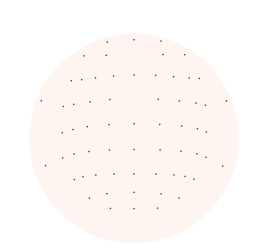

(<matplotlib.image.AxesImage at 0x7f9eb80c6970>,
 <matplotlib.contour.QuadContourSet at 0x7f9eb80fa490>)

In [34]:
standart_montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=standart_montage.ch_names, sfreq=100, ch_types='eeg')
info = info.pick_channels(ch_names = list(df_eeg.columns)[1:])

epochs = mne.EpochsArray(np.zeros([1, len(info.ch_names), 1]),  info=info)
epochs.set_montage(standart_montage)
info = epochs.info
x = np.zeros(63)
mne.viz.plot_topomap(x, pos = info)

## Model inference 

In [35]:
# common/koval_alvi/eeg-fmri-project/notebook_clean/
# common/koval_alvi/eeg-fmri-project/notebook_clean/
weight_path = 'wandb/run-20220512_215954-1xwjm7sz/files/epoch_1729_val_corr0.14.pt'

model = autoencoder_new_Artur.AutoEncoder1D_Artur_MultiHead(hp_autoencoder)

print(summary(model, torch.zeros(4, config['n_channels'],
                                 config['WINDOW_SIZE']), show_input=False))


model.load_state_dict(torch.load(weight_path))
model.eval()

print('s')

HOW:  {'n_electrodes': 63, 'n_freqs': 1, 'n_channels_out': 6, 'channels': [128, 128, 128, 128], 'kernel_sizes': [5, 5, 3], 'strides': [8, 8, 4], 'dilation': [1, 1, 1], 'decoder_reduce': 4}
HUI 6
-----------------------------------------------------------------------------
            Layer (type)        Output Shape         Param #     Tr. Param #
   AutoEncoder1D_Artur-1        [4, 1, 2048]         239,524         239,524
   AutoEncoder1D_Artur-2        [4, 1, 2048]         239,524         239,524
   AutoEncoder1D_Artur-3        [4, 1, 2048]         239,524         239,524
   AutoEncoder1D_Artur-4        [4, 1, 2048]         239,524         239,524
   AutoEncoder1D_Artur-5        [4, 1, 2048]         239,524         239,524
   AutoEncoder1D_Artur-6        [4, 1, 2048]         239,524         239,524
Total params: 1,437,144
Trainable params: 1,437,144
Non-trainable params: 0
-----------------------------------------------------------------------------
s


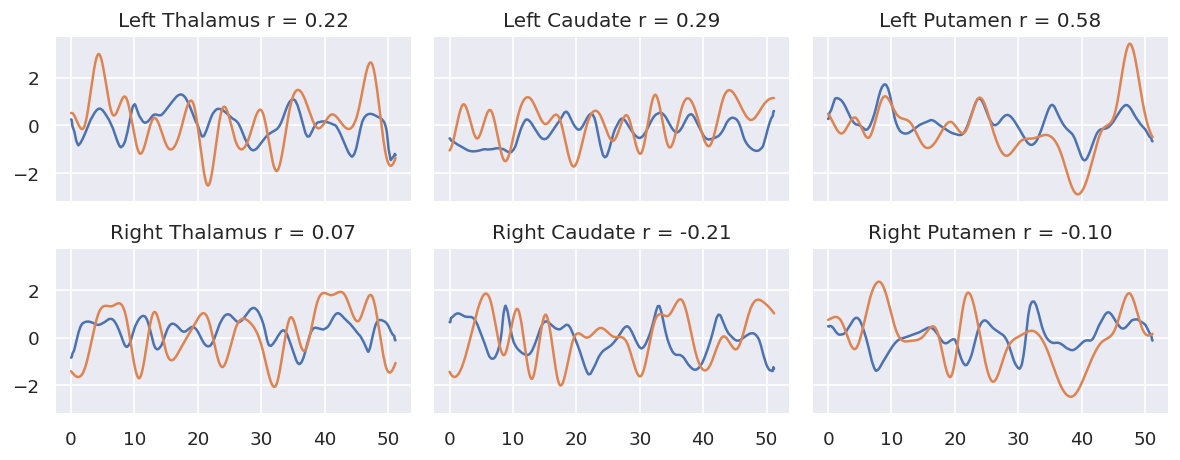

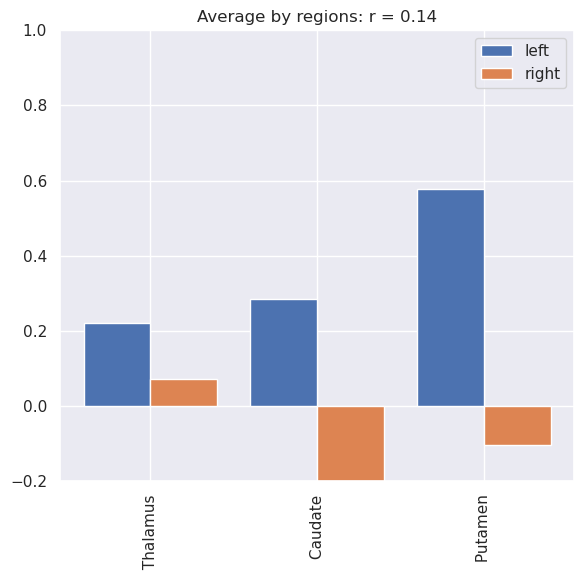

In [36]:
raw_test_data = test_dataset_prep
labels = labels_roi_6
inference_function = inference.model_inference_function
device = 'cuda'
to_many = True

fig, fig_bars, corrs = inference_function(model, raw_test_data, 
                                          labels=labels, 
                                          device=device, 
                                          to_many=to_many)



In [37]:
all_spatial_patterns = []
all_freq_patterns = []
all_freq_weights = []

for roi_idx in range(6):
    model_roi = model.models[roi_idx]

    weights = torch.squeeze(model_roi.artur_block.unmixing_layer.weight).detach().cpu()
    freq_filters = model_roi.artur_block.band_pass.weight.cpu().detach()
    eeg = torch.from_numpy(raw_test_data[0]).float()
    
    print('ALL sizes:', weights.shape, freq_filters.shape, eeg.shape)

    spatial_patterns = extract_spatial_patterns(eeg, weights, freq_filters)
    freqs_list, fft_patterns, fft_weights = extract_freq_patterns(eeg, weights, freq_filters)
    
    
    all_spatial_patterns.append(spatial_patterns)
    all_freq_patterns.append(fft_patterns)
    all_freq_weights.append(fft_weights)
    
    

ALL sizes: torch.Size([5, 63]) torch.Size([5, 1, 51]) torch.Size([63, 5400])
ALL sizes: torch.Size([5, 63]) torch.Size([5, 1, 51]) torch.Size([63, 5400])
ALL sizes: torch.Size([5, 63]) torch.Size([5, 1, 51]) torch.Size([63, 5400])
ALL sizes: torch.Size([5, 63]) torch.Size([5, 1, 51]) torch.Size([63, 5400])
ALL sizes: torch.Size([5, 63]) torch.Size([5, 1, 51]) torch.Size([63, 5400])
ALL sizes: torch.Size([5, 63]) torch.Size([5, 1, 51]) torch.Size([63, 5400])


### Get topomaps

0.0001244098 0.7700681
7.736683e-05 0.35400987


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

0.0013921857 0.55698806
0.00022933632 0.6199951


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

0.00014138222 0.5825082
2.8522685e-05 0.81768394


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

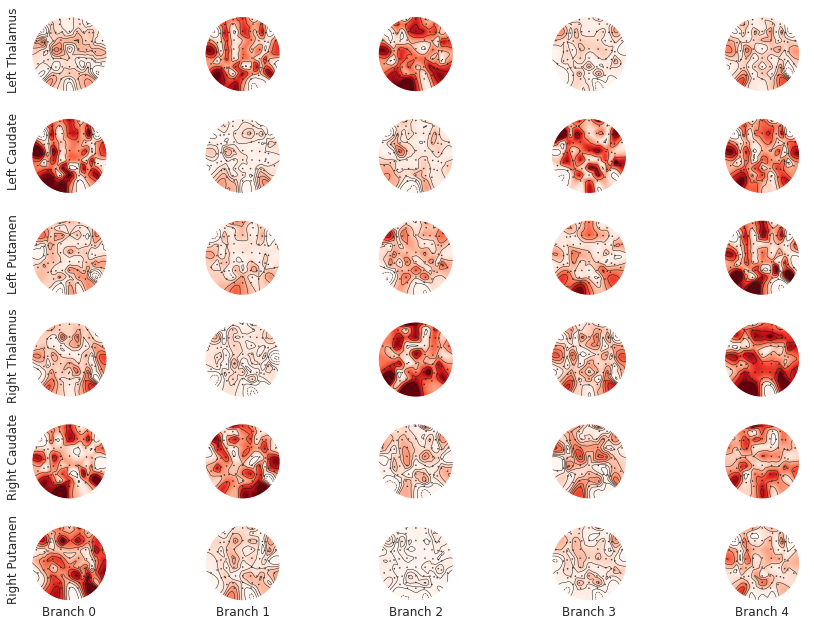

In [38]:
n_roi = 6
n_branch = 5
fig, ax = plt.subplots(n_roi, n_branch, figsize = (15, 10), sharex=True)
for roi in range(n_roi):
    # get v_min and v_max for each RoI
    # vmax = np.max([torch.max(pat) for pat in all_spatial_patterns[roi]])
    # vmin = np.min([torch.min(pat) for pat in all_spatial_patterns[roi]])
        # get v_min and v_max for each RoI
    vmax = np.max([torch.max(torch.abs(pat)) for pat in all_spatial_patterns[roi]])
    vmin = np.min([torch.min(torch.abs(pat)) for pat in all_spatial_patterns[roi]])
    print(vmin, vmax)
    
    for i in range(n_branch):
        # mne.viz.plot_topomap(all_spatial_patterns[roi][i], pos = info,
        #                      vmin = vmin, vmax =vmax, show=False, axes = ax[roi, i])
        mne.viz.plot_topomap(torch.abs(all_spatial_patterns[roi][i]), pos = info,
                             vmin = vmin, vmax =vmax, show=False, axes = ax[roi, i])
        ax[roi, i].set(xlabel=f"Branch {i}", ylabel=f"{labels[roi]}")
    
    
for ax in ax.flat:
    ax.label_outer()
    

### Get time freq

In [153]:
freqs_list

tensor([ 0.0000,  1.9608,  3.9216,  5.8824,  7.8431,  9.8039, 11.7647, 13.7255,
        15.6863, 17.6471, 19.6078, 21.5686, 23.5294, 25.4902, 27.4510, 29.4118,
        31.3725, 33.3333, 35.2941, 37.2549, 39.2157, 41.1765, 43.1373, 45.0980,
        47.0588])

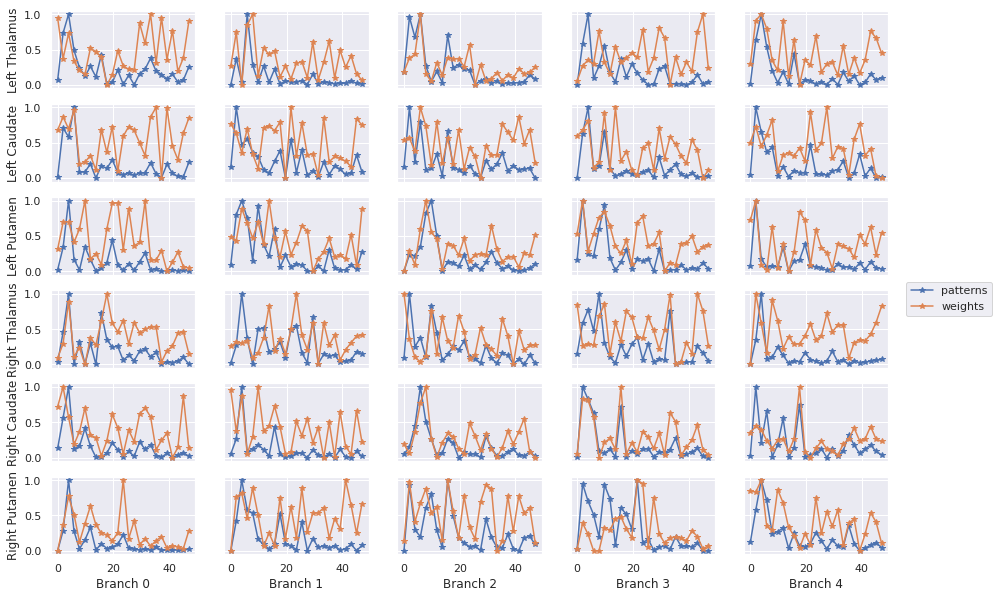

In [92]:
n_roi = 6
n_branch = 5
fig, ax = plt.subplots(n_roi, n_branch, figsize = (15, 10), sharex=True, sharey=False)
for roi in range(n_roi):
    for i in range(n_branch):
        pattern = minmax_scale(all_freq_patterns[roi][i].reshape(1, -1),axis= -1)[0]
        weight = minmax_scale(all_freq_weights[roi][i].reshape(1, -1),axis= -1)[0]
        
        ax[roi, i].plot(freqs_list, pattern , '*-', label='patterns')
        ax[roi, i].plot(freqs_list,weight  , '*-', label='weights')
        

        # mne.viz.plot_topomap(all_freq_patterns[roi][i], pos = info, show=False, axes = ax[roi, i])
        ax[roi, i].set(xlabel=f"Branch {i}", ylabel=f"{labels[roi]}")
    
    
for ax in ax.flat:
    # ax.set(xlabel='x-label', ylabel='y-label')
    ax.label_outer()


# for ax in fig.axes:
axLine, axLabel = fig.axes[0].get_legend_handles_labels()


    
fig.legend(axLine, axLabel,           
           loc = 'right')
# for ax in axs.flat:
    

## Apply sensitivity analysis


In [16]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [371]:
x, y = raw_test_data
model = model.to(device)
model.eval()
bound = x.shape[-1]//1024 * 1024

X_test = x[..., :bound]
y_test = y[..., :bound]

y_batch = torch.from_numpy(y_test).float().to(device)
y_batch = torch.unsqueeze(y_batch, 0)

x_batch = torch.from_numpy(X_test).float().to(device)
x_batch = torch.unsqueeze(x_batch, 0)


y_hat = model(x_batch)[0]
y_hats = y_hat.to('cpu').detach().numpy()

In [373]:
class fmriWrapper(torch.nn.Module):
    def __init__(self, model, y_batch): 
        super(fmriWrapper, self).__init__()
        self.model = model
        self.y_batch = y_batch
        
    def forward(self, x):
        return -(self.model(x) - self.y_batch)**2
        # return self.model(x)

In [374]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients, GuidedBackprop, Saliency
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

The common idea is to compute the gradient of the network’s prediction with respect to the input, holding the weights fixed. This determines which input elements (e.g., which pixels in case of an input image) need to be changed the least to affect the prediction the most. The sole difference between the three approaches is how they backpropagate through the linear rectifier [(the ReLU)]. Only [Simonyan et. al’s “Gradients” approach] actually computes the gradient; the others modify the backpropagation step to do something slightly different. As we will see, this makes a crucial difference for the saliency maps!

/tmp/ipykernel_3202/402948971.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_batch, requires_grad=True)


roi 0


/tmp/ipykernel_3202/59133328.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


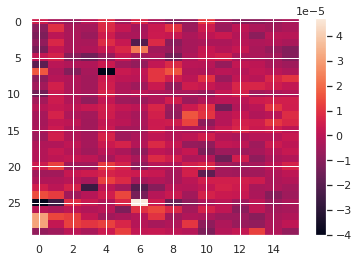

roi 1


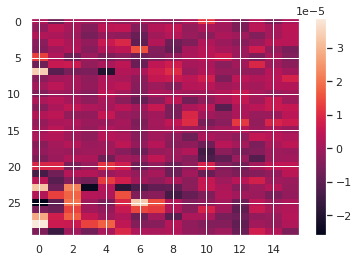

roi 2


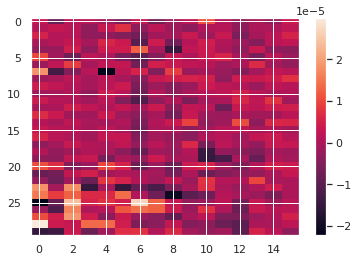

roi 3


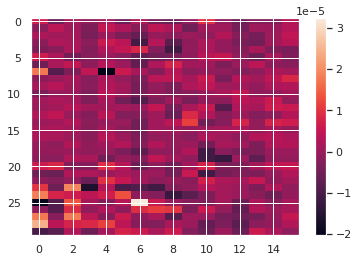

roi 4


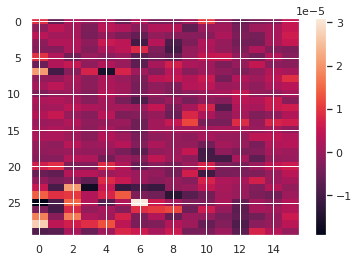

roi 5


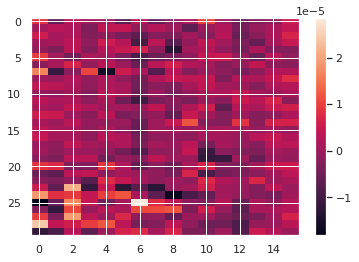

In [376]:
model_roi = fmriWrapper(model, y_batch)


# gbp = GuidedBackprop(model)
# ig = IntegratedGradients(model)
gradient = Saliency(model)

# ig = IntegratedGradients(net)

nt = NoiseTunnel(ig)


x_batch.requires_grad = True
x_batch = x_batch[..., :5000]
# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes Guided Backprop attribution scores for class 3.

attribution_freqs = []
matrixes = []
for roi in range(6):
    print('roi', roi)
    for i in range(0, 5000, 100):
        # baseline = torch.zeros_like(x_batch)+ torch.min(x_batch)
        attribution = gradient.attribute(x_batch, target=(roi, i), abs =False)
        # attribution = nt.attribute(x_batch, nt_type='smoothgrad',
                           # nt_samples=3, target=(roi, i))
        
        # attribution = torch.clip(attribution, 0, attribution.max())
        # attribution = torch.clip(attribution, attribution.min(), 0)
        
        # attribution = (attribution * x_batch).detach().numpy()  
        attribution = attribution.detach().numpy()
        
        
        attribution_freq = np.mean(attribution[0], -1)
        attribution_freqs.append(attribution_freq)
        # plt.imshow(attribution_freqs, aspect = 'auto')
        # plt.show()
        # plt.plot(np.mean(attribution_freqs, 0))
        # plt.show()

    matrix = np.mean(np.array(attribution_freqs), 0)
    matrixes.append(matrix)
    # matrix
    plt.imshow(matrix, aspect = 'auto')
    plt.colorbar()
    plt.show()

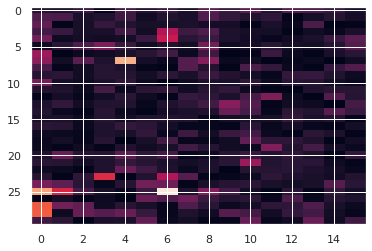

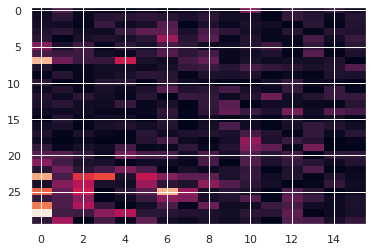

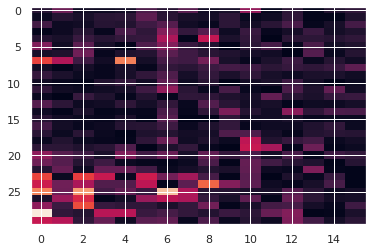

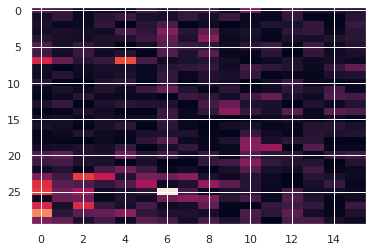

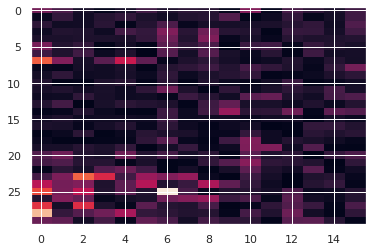

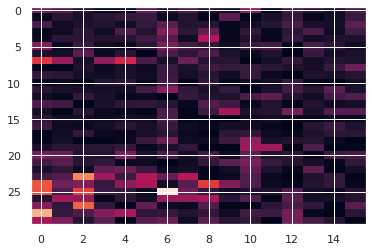

In [377]:
for i in range(6):
    plt.imshow(np.abs(matrixes[i]), aspect = 'auto')
    plt.show()

In [329]:
# matrixes_pos = matrixes.copy()

In [330]:
# matrixes_neg = matrixes.copy()

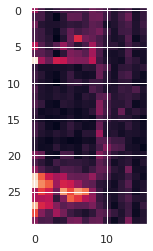

In [337]:
plt.imshow(np.abs(matrixes_pos[2]))

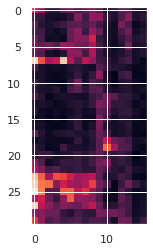

In [336]:
plt.imshow(np.abs(matrixes_neg[2]))

In [223]:
average = np.mean(np.array(matrixes), axis = 0)

In [230]:
diff = np.abs(np.array(matrixes)-  average)

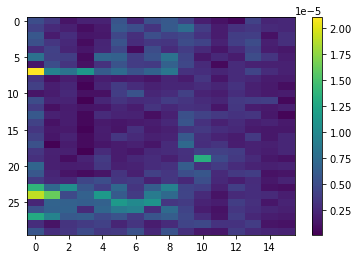

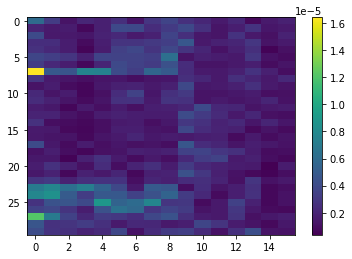

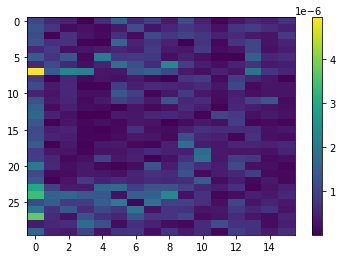

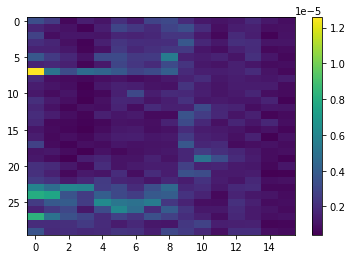

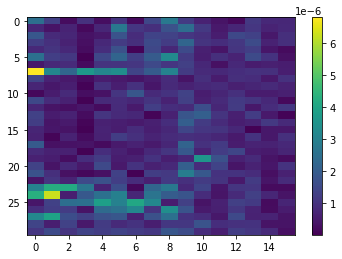

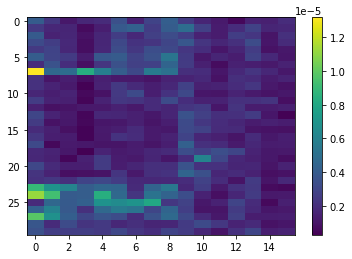

In [232]:
# matrixes.append(matrix)
# matrix
for i in range(6):
    plt.imshow(diff[i], aspect = 'auto') 
              # vmin = -17, vmax = -11)
    plt.colorbar()
    plt.show()

In [41]:
for i, freq in enumerate(config['freqs']):
    print(i, freq)

0 2.0
1 2.594201317699543
2 3.3649402383770237
3 4.364666200188945
4 5.66141140392441
5 7.343420462049961
6 9.525155519535902
7 12.355085500036555
8 16.025789542242673
9 20.78706217383076
10 26.96291204122704
11 34.97361097318403
12 45.36429383567262
13 58.84205542250558
14 76.32406885660676
15 99.0


In [391]:
top = np.mean(np.array(matrixes), 0)

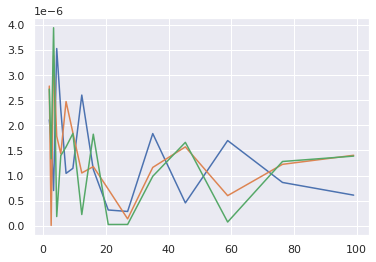

In [416]:
plt.plot(config['freqs'], np.abs(np.mean(matrixes[0], 0)))
plt.plot(config['freqs'], np.abs(np.mean(matrixes[1], 0)))
plt.plot(config['freqs'], np.abs(np.mean(matrixes[2], 0)))
# plt.plot(config['freqs'], np.abs(np.mean(matrixes[1], 0)))

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


(<matplotlib.image.AxesImage at 0x7f95321229a0>,
 <matplotlib.contour.QuadContourSet at 0x7f9532165a90>)

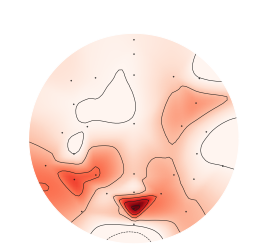

In [398]:
mne.viz.plot_topomap(np.mean(top, -1)**2, pos = info, show=False)

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

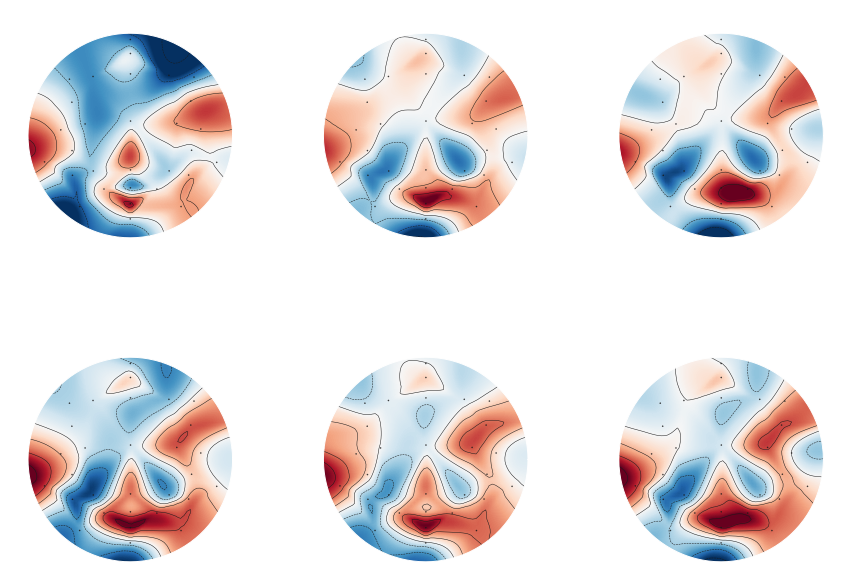

In [420]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(3):
    mne.viz.plot_topomap(np.mean(matrixes[i], -1), pos = info, show=False, axes = ax[0, i])
    # plt.show()
for i in range(3):
    mne.viz.plot_topomap(np.mean(matrixes[i+3], -1), pos = info, show=False, axes = ax[1, i])
    # plt.show()

In [421]:
fig.savefig('../figures/topomaps.pdf')

In [241]:
freqs

NameError: name 'freqs' is not defined

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packa

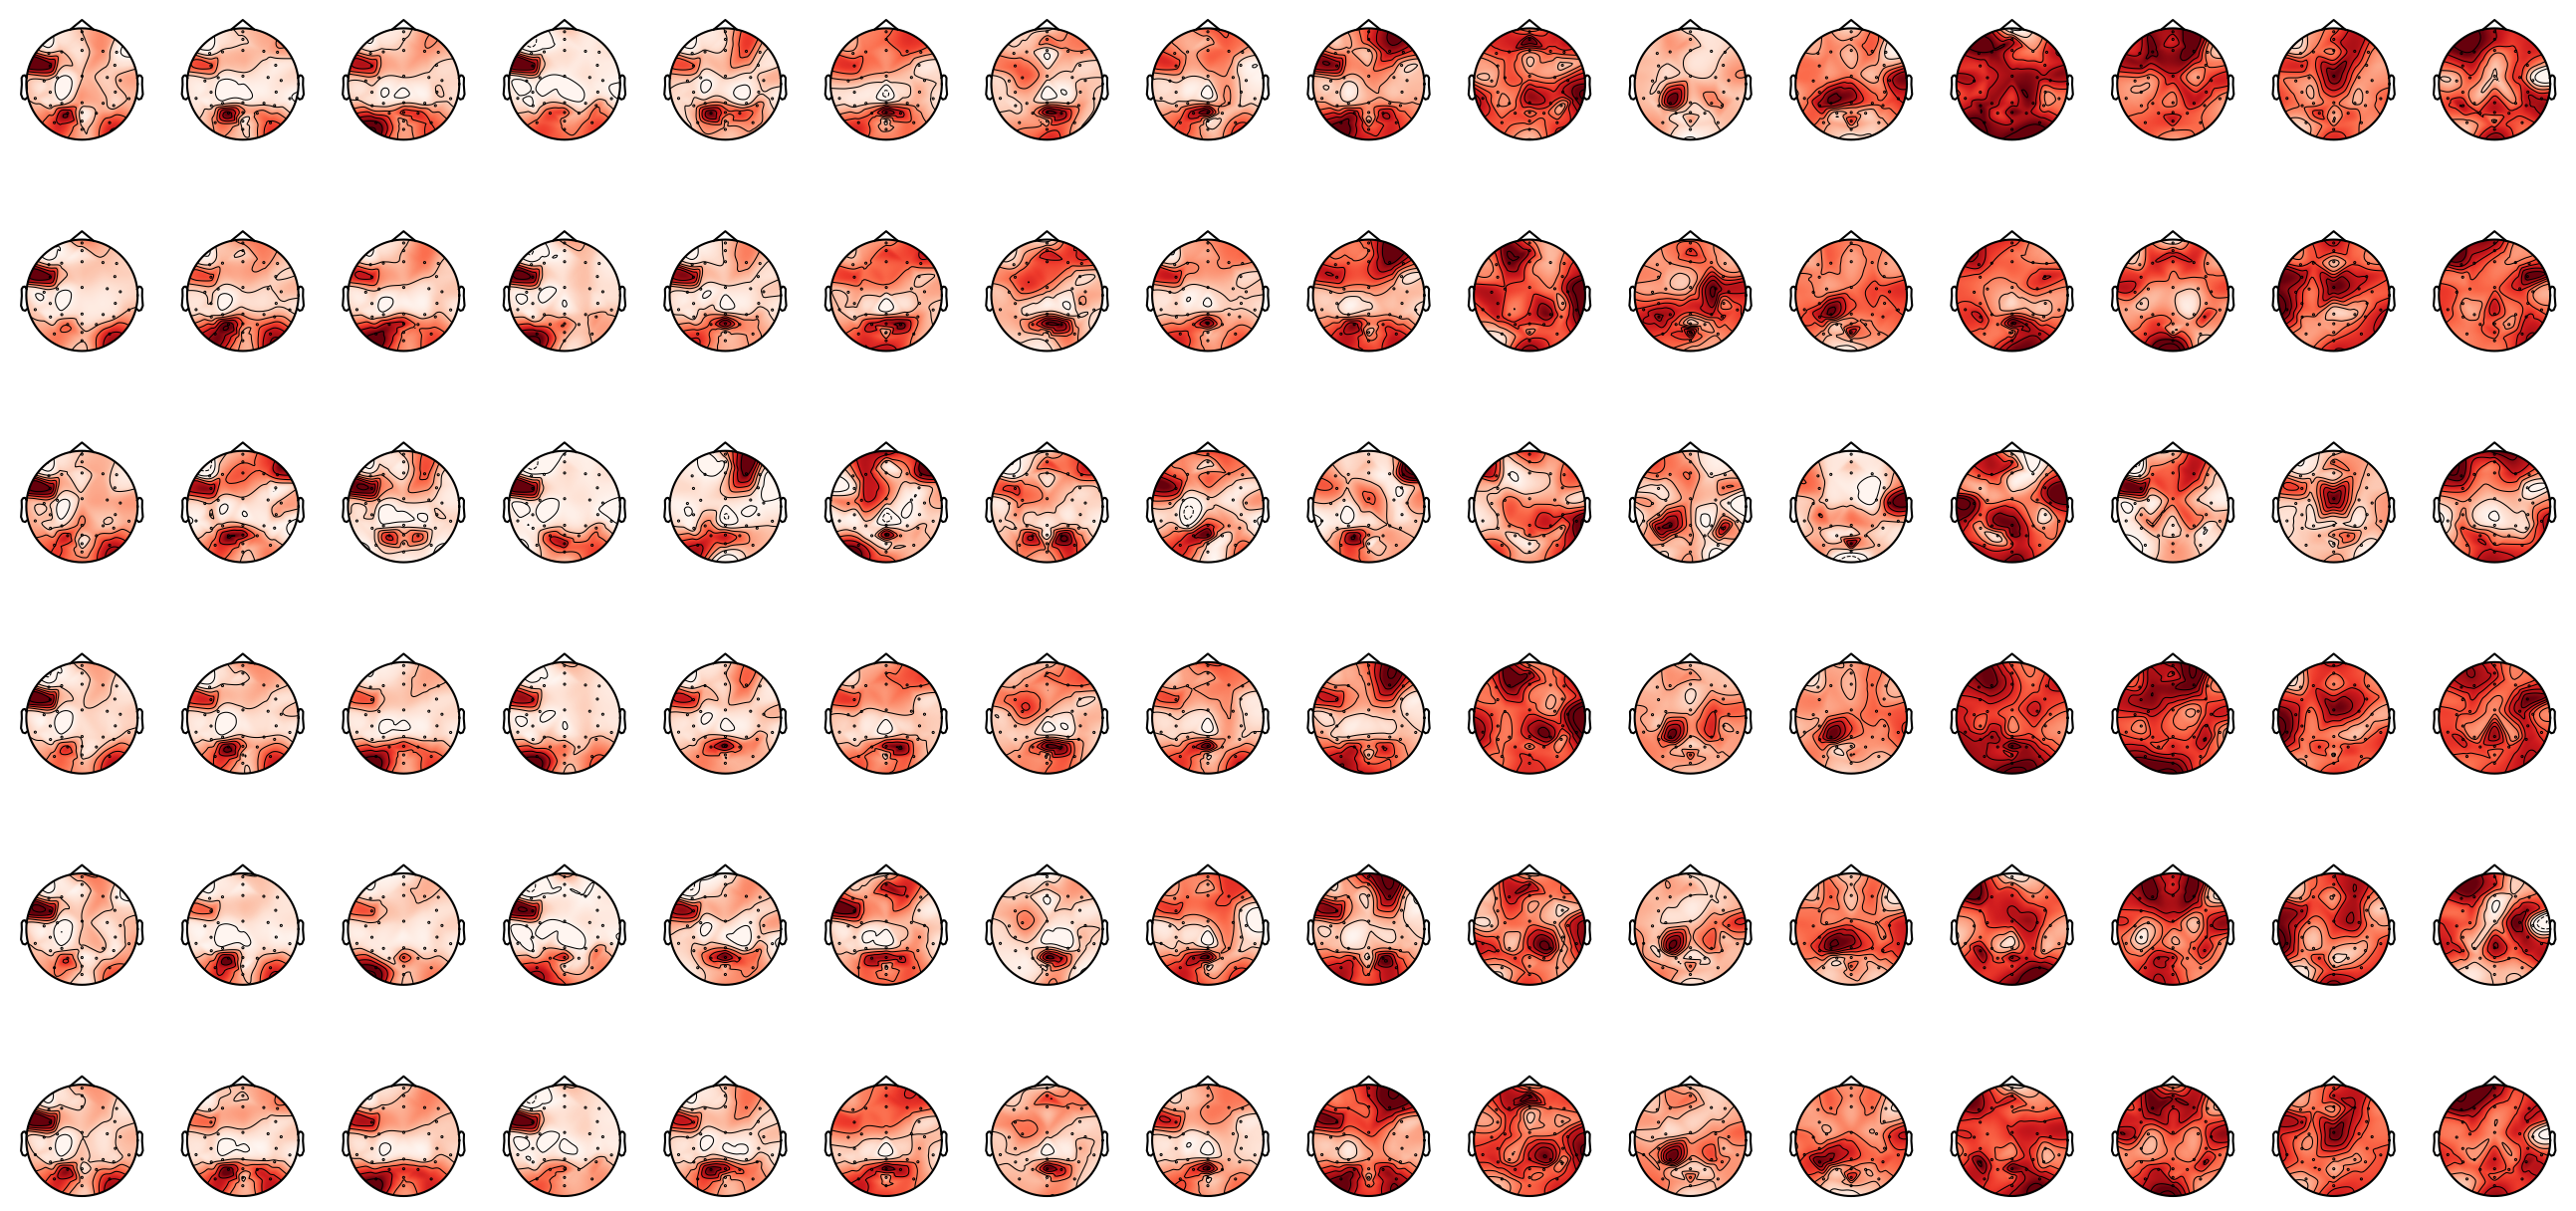

In [247]:
fig, axes = plt.subplots(6, 16, figsize = (22, 10), dpi = 150)
i = 0
# axis = ax.flat
for roi in range(6):
    for freq in range(16):
        data = diff[roi][:, freq]
        ax = axes[roi,freq]
        # ax.set_title(f"Roi {roi}, Band {config['freqs'][freq]} Hz")
        mne.viz.plot_topomap(data, pos = info, axes=ax, show=False)
        # ax.flat[i].plot(np.ones(5))
        i  = i +  1 
# plt.show()

In [248]:
fig.savefig('topomaps.png')

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


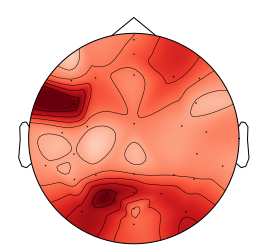

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


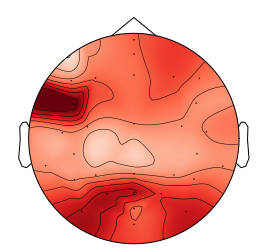

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


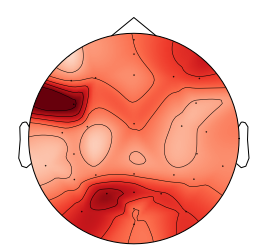

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


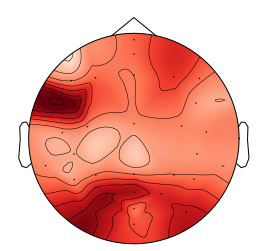

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


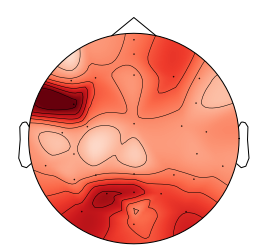

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


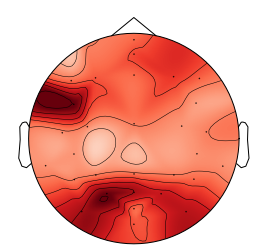

In [185]:
for roi in range(6):
    # plt.plot(np.mean(matrixes[roi], 0))
    # plt.plot(np.mean(np.abs(matrixes[roi] - average), 1))
    mne.viz.plot_topomap(np.mean(np.abs(matrixes[roi] - average), 1), pos = info)
    plt.show()
# plt.plot(matrixes[1][0])

In [ ]:
attribution.numpy()

In [ ]:
print(attribution.shape)
# attribution = np.abs((attribution * x_batch).detach().numpy())
attribution_reshape = attribution[0].reshape(16*30, -1)

attribution_freqs = np.mean(attribution[0], -1)

In [ ]:
attribution_freqs.shape
plt.imshow(attribution_freqs, aspect = 'auto')


In [ ]:
plt.plot(attribution[0][0].**0.5, aspect = 'auto')


In [ ]:
plt.figure(figsize = (15, 7))
plt.imshow(attribution_reshape**0.5, aspect = 'auto')
plt.colorbar()

In [ ]:
plt.plot(np.mean(attribution_reshape**0.5, 0))


In [ ]:
plt.imshow(attribution[0, :, :, 0])

In [ ]:
X_test = x_batch
baseline = y_batch

# ig = IntegratedGradients(model)
# ig_nt = NoiseTunnel(ig)
# dl = DeepLift(model)
gs = GradientShap(model_roi)
fa = FeatureAblation(model_roi)

# ig_attr_test = ig.attribute(X_test, n_steps=50, target = 0)
# ig_nt_attr_test = ig_nt.attribute(X_test)
# dl_attr_test = dl.attribute(X_test)
# gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

In [ ]:
weight = model.spatial_reduce.conv1d.weight
weight = weight.detach().numpy()

In [ ]:
weight_sum = np.mean(weight, -1)

In [ ]:
plt.imshow(np.abs(weight_sum[:, :]), aspect = 'auto')

In [ ]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)